In [1]:
# print out each line in the input cell not only the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# expand the cell width to 100% of t 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

Install commands: 

`sudo pip install numba`

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List 

In [3]:
def initialize_julia_sets(constant_c, formula, x_start, x_end, y_start, y_end, scaling):
    """
    Initializes the parameters for generating Julia sets.

    Args:
        constant_c (complex): The constant value used in the Julia set formula.
        formula (str): The formula used for generating the Julia set.
        x_start (float): The starting value for the x-axis range.
        x_end (float): The ending value for the x-axis range.
        y_start (float): The starting value for the y-axis range.
        y_end (float): The ending value for the y-axis range.
        scaling (int): The scaling factor used for incrementing the values.

    Returns:
        dict: A dictionary containing the initialized parameters for generating Julia sets.
            - 'constant_c': The constant value used in the Julia set formula.
            - 'formula': The formula used for generating the Julia set.
            - 'x_start': The starting value for the x-axis range.
            - 'x_end': The ending value for the x-axis range.
            - 'y_start': The starting value for the y-axis range.
            - 'y_end': The ending value for the y-axis range.
            - 'scaling': The scaling factor used for incrementing the values.
    """
    return {
        'constant_c': constant_c,
        'formula': formula,
        'x_start': x_start,
        'x_end': x_end,
        'y_start': y_start,
        'y_end': y_end,
        'scaling': scaling
    }

In [4]:
def initialize_matrix(setup):
    """
    Initializes a matrix using the provided setup parameters.

    Args:
        setup (dict): A dictionary containing the setup parameters for matrix initialization.

    Returns:
        Matrix: The initialized matrix.

    """
    matrix_list = []

    for col in np.arange(setup['x_start'], setup['x_end'] + 1, 1 / setup['scaling']):
        col_list = []

        for row in np.arange(setup['y_start'], setup['y_end'] + 1, 1 / setup['scaling']):
            col_list.append(col + row * 1j)
        matrix_list.append(col_list)

    return matrix_list

In [5]:
@njit
def validate_point(complex_number, constant_c):
    """
    Validates a complex number using the given constant_c.

    Args:
        complex_number (complex): The initial complex number to be validated.
        constant_c (complex): The constant complex number.

    Returns:
        int: The number of iterations until the complex number exceeds the validation bounds or the maximum number of iterations is reached.

    """
    run = 200

    while -100 < complex_number.real < 100 and run > 0:
        complex_number = complex_number * complex_number + constant_c
        run -= 1

    return run

In [6]:
@njit
def change_matrix(matrix_complex_numbers, x_start, x_end, y_start, y_end, constant, matrix_scaling):
    """
    Changes the matrix of complex numbers using the given constant and scaling.

    Args:
        matrix_complex_numbers (list): The matrix of complex numbers to be modified.
        x_start (float): The starting value of the x-axis.
        x_end (float): The ending value of the x-axis.
        y_start (float): The starting value of the y-axis.
        y_end (float): The ending value of the y-axis.
        constant (complex): The constant complex number.
        matrix_scaling (int): The scaling factor for the matrix.

    Returns:
        list: The modified matrix.

    """
    final_matrix = []

    for row in range((y_end - y_start) * matrix_scaling + 1):
        rows = []
        for col in range((x_end - x_start) * matrix_scaling + 1):
            rows.append(validate_point(matrix_complex_numbers[col][row], constant))
        final_matrix.append(rows)

    return final_matrix

In [7]:
def create_picture(final_matrix):
    """
    Creates and displays a picture using the final matrix.

    Args:
        final_matrix: The matrix representing the picture.

    """
    plt.imshow(final_matrix)
    plt.axis('off')
    plt.axis('tight')
    plt.set_cmap('seismic')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.show()

Initialize setup...
Initialize done: 0.0 seconds!
Initialize Matrix...
Initialize done: 0.01 seconds!
Calculating....
Calculation done: 0.0 seconds!


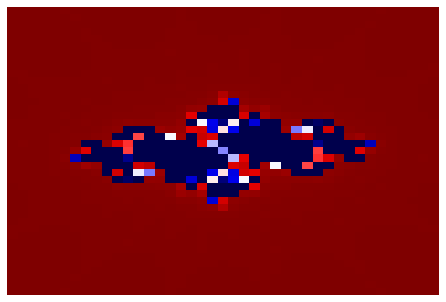

Overall time: 0.07 seconds!


In [11]:
t2 = time.time()

print('Initialize setup...')

t0 = time.time()

# Initialize setup parameters
setup = initialize_julia_sets(-0.7423 + 0.105j, 'x^2+c', -2, 2, -2, 2, 10)
func = setup['formula']

t1 = time.time()

print('Initialize done: ' + str(round(t1 - t0, 2)) + ' seconds!')

print('Initialize Matrix...')

t0 = time.time()

# Initialize matrix
matrix = initialize_matrix(setup)

t1 = time.time()

print('Initialize done: ' + str(round(t1 - t0, 2)) + ' seconds!')

converter_list = List()

for index in matrix:
    converter_list.append(index)

print('Calculating....')

t0 = time.time()

# Change matrix values
matrix = change_matrix(converter_list, setup['x_start'], setup['x_end'], setup['y_start'], setup['y_end'], setup['constant_c'], setup['scaling'])

t1 = time.time()

print('Calculation done: ' + str(round(t1 - t0, 2)) + ' seconds!')
create_picture(matrix)

t3 = time.time()

print('Overall time: ' + str(round(t3 - t2, 2)) + ' seconds!')